In [47]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [49]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
download.file(players_url, "players.csv")
players_data <- read_csv("players.csv")

players_data 


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA


In [63]:

age_data <- players_data|>
    select(age, played_hours)
           
age_data

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
⋮,⋮
17,0.0
17,2.3
91,0.2


In [59]:
set.seed(411)

age_split <- initial_split(age_data, prop=0.75, strata = played_hours)
age_training <- training(age_split)
age_testing <- testing(age_split)

In [60]:
set.seed(411)

age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("regression")

age_recipe <- recipe(played_hours ~ age, data = age_training)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

age_vfold <- vfold_cv(age_training, v=5, strata = played_hours)

age_workflow <- workflow()|>
    add_recipe(age_recipe)|>
    add_model(age_spec)

age_workflow
    

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [61]:
set.seed(411)

gridvals <- tibble(neighbors = seq(1, 113, by = 2))

age_results <- age_workflow|>
    tune_grid(resamples = age_vfold, grid = gridvals)|>
    collect_metrics()|>
    filter(.metric=="rmse")
 
age_results

age_min <- age_results|>
    filter(mean==min(mean))

age_min

kmin <- age_min|>
    pull(neighbors)

age_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

age_best_fit <- workflow() |>
  add_recipe(age_recipe) |>
  add_model(age_best_spec) |>
  fit(data = age_training)

age_rmse <- age_best_fit |>
  predict(age_testing) |>
  bind_cols(age_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

age_rmse

→ A | warning: 113 samples were requested but there were 115 rows in the data. 110 will be used.

There were issues with some computations   A: x1

→ B | warning: 113 samples were requested but there were 117 rows in the data. 112 will be used.

There were issues with some computations   A: x1
→ C | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x3   C: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,29.47412,5,10.437025,Preprocessor1_Model01
3,rmse,standard,26.98451,5,9.512896,Preprocessor1_Model02
5,rmse,standard,29.49213,5,8.143220,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
109,rmse,standard,28.20499,5,8.061392,Preprocessor1_Model55
111,rmse,standard,28.17262,5,8.084976,Preprocessor1_Model56
113,rmse,standard,28.16475,5,8.098138,Preprocessor1_Model57


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,26.98451,5,9.512896,Preprocessor1_Model02


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.636651


.pred,age,played_hours
<dbl>,<dbl>,<dbl>
0.00000000,17,0.0
0.06666667,21,0.1
0.00000000,17,0.0
⋮,⋮,⋮
0,22,0.8
0,22,32.0
0,17,2.3


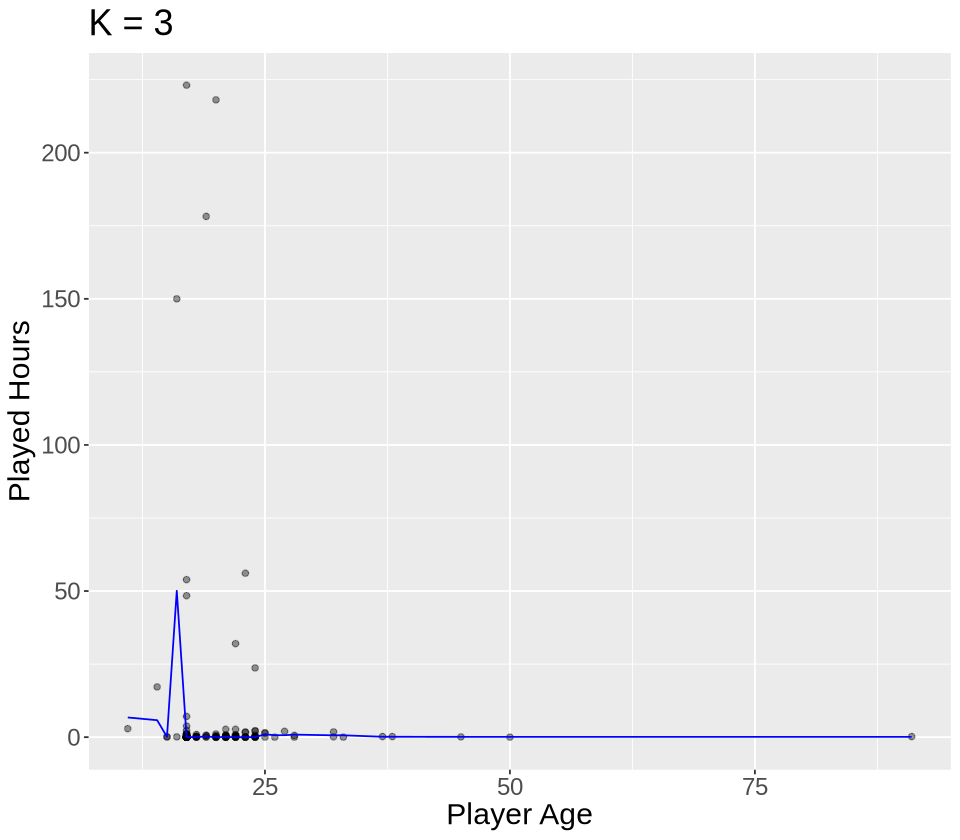

In [62]:
set.seed(411)
options(repr.plot.width=8, repr.plot.height=7)

age_prediction_grid <- tibble(age = seq(from = players_data |> select(age) |> min(), 
                                        to = players_data|> select(age) |> max(), by = 10))

age_preds <- age_best_fit|>
predict(age_training)|>
bind_cols(age_training)

age_preds

age_plot <- age_preds|>
    ggplot(aes(x= age, y=played_hours))+
    geom_point(alpha = 0.4)+
    geom_line(data = age_preds, mapping =aes(x=age,y=.pred),
              color="blue")+
    labs(x="Player Age", y= "Played Hours", title= "Player Age vs Played Hours")+
    ggtitle(paste0("K = ", kmin))+
    theme(text = element_text(size = 18))

age_plot